In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import pandas as pd
import numpy as np 

import create_model
import pickle
import time 

import random
import data_formatting

def encodeSent(sent):

    if type(sent) == str: sent = sent.split(' ')
    
    return [vocab_dict[word] if word in vocab_dict else 2 for word in sent]

def decodeSent(sent):
    return [inv_map[i] for i in sent if i!=0]

def validate(train):
    
    if train == True:
        
        model = train_model
        mode = 'TRAIN'
        
    else:
        mode = 'DEV'
        model = dev_model

    encoder, decoder, predicted = session.run([model.encoder_inputs, model.decoder_targets, model.decoder_pred_train])            

    print ('Current mode:%s' % mode)
    for i, (e_in, dt_targ, dt_pred) in enumerate(zip( encoder, decoder, predicted)):

        print('  sample {}:'.format(i + 1))
        #print('    enc input           > {}'.format(e_in))
        print('    enc input           > {}'.format(decodeSent(e_in)))

        #print('    dec input           > {}'.format(dt_targ))
        print('    dec input           > {}'.format(decodeSent(dt_targ)))

        #print('    dec train predicted > {}'.format(dt_pred))
        print('    dec train predicted > {}'.format(decodeSent(dt_pred)))

        if i >= 0: break

In [2]:
dataset = 'twitter'

#vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_4_15_sample_134241_full.pkl', 'rb'))
#df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_4_15_sample_134241_full.pkl')

vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_3_19_sample_21946_lem.pkl', 'rb'))
df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_3_19_sample_21946_lem.pkl')

In [3]:
df_all['alpha_Pair_1_encoding'] =  df_all['alpha_Pair_1_tokens'].apply(encodeSent)
df_all['alpha_Pair_0_encoding'] = df_all['alpha_Pair_0_tokens'].apply(encodeSent)

df_all['Index'] = df_all.index.values

df_all_train = df_all.sample(frac=0.95, random_state=1)

df_all_dev = df_all[df_all['Index'].isin(df_all_train['Index'].values) == False]

df_all_test = df_all_dev.sample(frac=0.10, random_state=1)

df_all_dev = df_all_dev[df_all_dev['Index'].isin(df_all_test['Index'].values) == False]

In [4]:
df_all.shape[0], df_all_train.shape[0],  df_all_dev.shape[0], df_all_test.shape[0]

(17690, 16806, 796, 88)

In [5]:
training_data = data_formatting.prepare_train_batch(df_all_train['alpha_Pair_0_encoding'].values, 
                                                    df_all_train['alpha_Pair_1_encoding'].values)

dev_data = data_formatting.prepare_train_batch(df_all_dev['alpha_Pair_0_encoding'].values, 
                                                    df_all_dev['alpha_Pair_1_encoding'].values)

test_data = data_formatting.prepare_train_batch(df_all_test['alpha_Pair_0_encoding'].values, 
                                                    df_all_test['alpha_Pair_1_encoding'].values)

In [6]:
#df_all_train['alpha_Pair_0_encoding'] = df_all_train['alpha_Pair_0_encoding'].apply(lambda x: ' '.join([str(i) for i in x]))
#df_all_train['alpha_Pair_1_encoding'] = df_all_train['alpha_Pair_1_encoding'].apply(lambda x: ' '.join([str(i) for i in x]))

#df_all_dev['alpha_Pair_0_encoding'] = df_all_dev['alpha_Pair_0_encoding'].apply(lambda x: ' '.join([str(i) for i in x]))
#df_all_dev['alpha_Pair_1_encoding'] = df_all_dev['alpha_Pair_1_encoding'].apply(lambda x: ' '.join([str(i) for i in x]))

In [7]:
inv_map = {v: k for k, v in vocab_dict.items()}
inv_map[-1] = 'NULL'

In [8]:
train_model_params = {'n_cells':256, 'num_layers':2, 'embedding_size':1024, 
          'vocab_size':len(vocab_dict) + 1, 'minibatch_size':128, 'n_threads':128,
         # 'vocab_size':20 + 1,           
          'beam_width':10, 
          'encoder_input_keep':0.5, 'decoder_input_keep':0.5,
          'encoder_output_keep':0.5, 'decoder_output_keep':0.5,
         }

In [9]:
dev_model_params = {'n_cells':256, 'num_layers':2, 'embedding_size':1024, 
          'vocab_size':len(vocab_dict) + 1, 'minibatch_size':128, 'n_threads':128,
         # 'vocab_size':20 + 1,           
          'beam_width':10, 
          'encoder_input_keep':1, 'decoder_input_keep':1,
          'encoder_output_keep':1, 'decoder_output_keep':1,
         }

In [11]:
training_params = { 'vocab_lower':3, 'vocab_upper':train_model_params['vocab_size']-1, 
                    'n_epochs':5000}

In [12]:
len(vocab_dict)

17322

In [13]:
encoder_dropout = [0.2, 0.7]
decoder_dropout = [0.2, 0.7]
hidden_units = [256, 512]
n_layers = [1, 2, 4]
embedding_size = [512, 1024, 2048]

grid_search_results = []

pickle.dump(grid_search_results, open('grid_search_results.pkl', 'wb'))

count = 0
for param_0 in encoder_dropout:
    for param_1 in decoder_dropout:
        for param_2 in hidden_units:
            for param_3 in n_layers:
                for param_4 in embedding_size:
                    count = count + 1
                    if count < 14: continue
                    search_start_time = time.time()
                    
                    print ('current grid point, ', param_0, param_1, param_2, param_3, param_4)
                    
                    
                    search_model_params = {'n_cells':param_2, 'num_layers':param_3, 'embedding_size':param_4, 
                      'vocab_size':len(vocab_dict) + 1, 'minibatch_size':32, 'n_threads':128,
                      'beam_width':10, 'encoder_output_keep':param_0, 'decoder_output_keep':param_1,
                                           }
                    
                    tf.reset_default_graph()                    
                    
                    grid_search_results.append([[param_0, param_1, param_2, param_3, param_4],
                                                gridSearch(search_model_params, training_params), search_run_time])
                    
                    search_run_time = str(time.time() - search_start_time)

                    print ('current grid point finished, time:%s s' % search_run_time)

#pickle.dump(grid_search_results, open('seq2seq_grid_search_results_part_1_at_0.2_0.7_256_2_512.pkl', 'wb'))
pickle.dump(grid_search_results, open('seq2seq_grid_search_results_part_2.pkl', 'wb'))

grid_points_1 = pickle.load( open('seq2seq_grid_search_results_part_1_at_0.2_0.7_256_2_512.pkl', 'rb'))
grid_points_2 = pickle.load( open('seq2seq_grid_search_results_part_2.pkl', 'rb'))

def gridSearch(train_model_params, dev_model_params, training_params):
    
    tf.reset_default_graph()

    with tf.variable_scope('training_model'):

        train_model = create_model.Model(train_model_params, 'train', training_data)

    with tf.variable_scope('training_model', reuse=True):

        dev_model = create_model.Model(dev_model_params, 'train', dev_data)

    global_step = tf.Variable(0, trainable=False)

    starter_learning_rate = tf.placeholder(tf.float32,shape=(),name='starter_learning_rate')

    #starter_learning_rate = 0.01

    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, \
                                       training_params['n_epochs'], 0.0001, staircase=False)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    train_op = optimizer.minimize(train_model.loss, global_step=global_step)

    print_interval = 100
    save_interval = 1000

    lr = 0.001

    train_loss = []
    dev_loss = []
    learning_rate = []

    with tf.Session() as session:

        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

        coord = tf.train.Coordinator()

        threads = tf.train.start_queue_runners(coord=coord)
        #saver.restore(session, 'chkpt/seq2seq_twitter_queue-24005')


        for epoch in range(training_params['n_epochs']):

            start_time = time.time()

            session.run(train_op, feed_dict={'starter_learning_rate:0':lr})

            if epoch % print_interval == 0: 

                print ('epoch:%d, global_step:%s, learning rate:%.3g' % 
                           (epoch, tf.train.global_step(session, global_step), 
                            session.run(optimizer._lr, feed_dict={'starter_learning_rate:0':lr})))

                train_minibatch_loss = session.run(train_model.loss, feed_dict={'starter_learning_rate:0':lr})

                train_loss.append([tf.train.global_step(session, global_step), train_minibatch_loss])  

                print ('training minibatch loss:%.6g' % (train_minibatch_loss))

                #validate(train=True)

                dev_model_loss = session.run(dev_model.loss)            

                print ('dev minibatch loss:%.6g' %  (dev_model_loss))

                dev_loss.append([tf.train.global_step(session, global_step), dev_model_loss])


                learning_rate.append([tf.train.global_step(session, global_step), 
                                      session.run(optimizer._lr, feed_dict={'starter_learning_rate:0':lr})])

                #validate(train=False)

                print ('Epoch:%d finished, time:%s s' % (epoch, str(time.time() - start_time)))

            #if (epoch % save_interval == 0) & (epoch!=0): 

                #saver.save(session, 'chkpt/seq2seq_twitter_queue', global_step = tf.train.global_step(session, global_step))

                #print ('Session saved')

        coord.request_stop()
        # ... and we wait for them to do so before releasing the main thread
        coord.join(threads)

    session.close()
    
    return train_loss, dev_loss, learning_rate

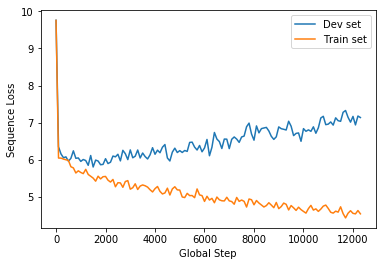

In [19]:
plt.plot(list(zip(*dev_loss))[0], list(zip(*dev_loss))[1], label='Dev set')
plt.plot(list(zip(*train_loss))[0], list(zip(*train_loss))[1], label='Train set')
plt.xlabel('Global Step')
plt.ylabel('Sequence Loss')
#plt.title('Seq2Seq Twitter Data')
#plt.title(' '.join(['%s:%d' % (i, j) for i,j in zip(model_params.keys(), model_params.values())]))
plt.legend(loc='best')
plt.show()

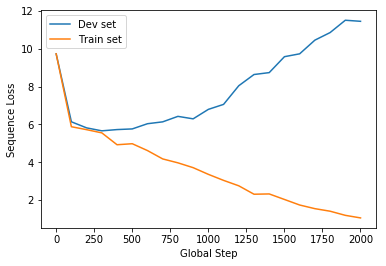

In [37]:
plt.plot(list(zip(*dev_loss))[0], list(zip(*dev_loss))[1], label='Dev set')
plt.plot(list(zip(*train_loss))[0], list(zip(*train_loss))[1], label='Train set')
plt.xlabel('Global Step')
plt.ylabel('Sequence Loss')
#plt.title('Seq2Seq Twitter Data')
#plt.title(' '.join(['%s:%d' % (i, j) for i,j in zip(model_params.keys(), model_params.values())]))
plt.legend(loc='best')
plt.show()

In [7]:
tf.reset_default_graph()

In [8]:
inf_model = create_model.Model(dev_model_params, 'infer')

In [45]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    coord = tf.train.Coordinator()
   
    threads = tf.train.start_queue_runners(coord=coord)
    saver.restore(session, 'chkpt/seq2seq_twitter_queue-12001')
    
    #inf_out = session.run([inf_model.decoder_pred_decode, inf_model.decoder_pred_decode_prob], feed_dict_inf)
    inf_out = session.run([inf_model.encoder_inputs, inf_model.decoder_targets, inf_model.decoder_pred_decode])
    
    encoder_input = inf_out[0]
    decoder_target = inf_out[1]
    decoder_inference = inf_out[2]
    
    coord.request_stop()
    # ... and we wait for them to do so before releasing the main thread
    coord.join(threads)
    for idx, (e_in, dt_in) in enumerate(zip(encoder_input, decoder_target)):
                
        print ('###%d###' % idx)
        
        print ('e_in', decodeSent(e_in))
        print ('d_in', decodeSent(dt_in))        
        beam_inf = list(zip(*decoder_inference[idx]))
        for idx_inf, dt_inf in enumerate(beam_inf):

            print ('dt_inf', decodeSent(dt_inf))
            if idx_inf>1: break
                

INFO:tensorflow:Restoring parameters from chkpt/seq2seq_twitter_queue-12001


INFO:tensorflow:Restoring parameters from chkpt/seq2seq_twitter_queue-12001


###0###
e_in ['yeah', 'cause', 'he', 'the', 'man', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
d_in ['to', 'be', 'honest', 'i', 'fuck', 'wit', 'wale', 'heavy', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
dt_inf ['i', 'don', 't', 'know', 'what', 'i', 'said', '<EOS>', '<EOS>', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
dt_inf ['i', 'don', 't', 'know', 'what', 'i', 'said', '<EOS>', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
dt_inf ['i', 'don', 't', 'know', 'what', 'i', 'said', '?', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
dt_inf ['i', 'don', 't', 'think', 'he', 's', 'so', 'pissed', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
###1###
e_in ['i', 'wouldn', 't', 'be', 'able', 'to', 'sleep', 'with', 'my', 'phone', 'buzzing', 'all', 'night', '<EOS>', '<PAD>']
d_in ['not', 'a', 'rip', 'off', 'just', 'heavily', 'influenced', 'theyre', 'different', 'enough', '<EOS>', '<PAD>', '<PAD>', 

dt_inf ['i', 'think', 'i', 'wa', 'joking', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
dt_inf ['i', 'think', 'i', 'wa', 'thinking', 'about', 'this', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
dt_inf ['i', 'think', 'i', 'wa', 'thinking', 'about', 'that', '<EOS>', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
###100###
e_in ['a', 'ticket', 'is', 'the', 'only', 'thing', 'he', 'should', 'have', 'gotten', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
d_in ['lol', 'i', 'guess', 'it', 'wa', 'night', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
dt_inf ['what', 'is', 'this', '?', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
dt_inf ['what', 'is', 'this', '?', '?', '<EOS>', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
dt_inf ['what', 'is', 'this', '?', '?', '<EOS>', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', '